## install pDESy from github

## Import pDESy modules and python modules

In [1]:
import datetime

import pDESy
from pDESy.model.base_project import BaseProject
from pDESy.model.base_product import BaseProduct
from pDESy.model.base_component import BaseComponent
from pDESy.model.base_workflow import BaseWorkflow
from pDESy.model.base_task import BaseTask
from pDESy.model.base_organization import BaseOrganization
from pDESy.model.base_team import BaseTeam
from pDESy.model.base_worker import BaseWorker
from pDESy.model.base_facility import BaseFacility
from pDESy.model.base_workplace import BaseWorkplace
from pDESy.model.base_priority_rule import TaskPriorityRuleMode,BasePriorityRule

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

## Define Project 
* 1.Define Product model
* 2.Define Workflow model
* 3.Define Organization model (this model includes Workplace model and Team model)

In [2]:
#define project 

project = BaseProject(init_datetime = datetime.datetime(2021, 5, 1,8, 0, 0), unit_timedelta=datetime.timedelta(days=1))

<img width="718" alt="スクリーンショット 2021-05-06 9 41 44" src="https://user-images.githubusercontent.com/40065086/117226312-55cbc880-ae4f-11eb-8d1e-f70ffe7c0210.png">




### 1.Define Product model

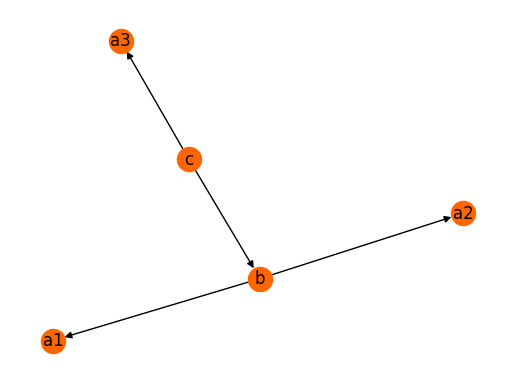

In [3]:
# Components in Product
a1 = BaseComponent('a1')
a2 = BaseComponent('a2')
a3 = BaseComponent('a3')
b = BaseComponent('b')
c = BaseComponent('c')

# dependencies between companies 
b.extend_child_component_list([a1, a2]) # ex) b is composed a1 and a2
c.extend_child_component_list([a3, b])

# Register Product including Components in Project
project.product = BaseProduct([a1, a2, a3, b, c])

# draw produt network
project.product.draw_networkx()


### 2.Define Workflow model

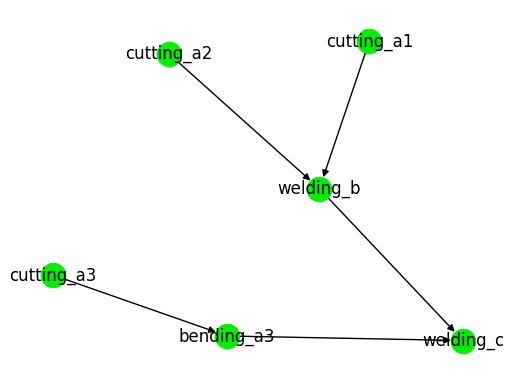

In [4]:
# Tasks in Workflow 
# define work_amount and whether or not to need facility for each task
cutting_a1 = BaseTask('cutting_a1', need_facility=True, default_work_amount=10)
cutting_a2 = BaseTask('cutting_a2', need_facility=True, default_work_amount=10)
cutting_a3 = BaseTask('cutting_a3', need_facility=True, default_work_amount=20)
bending_a3 = BaseTask('bending_a3', need_facility=True, default_work_amount=20)
welding_b = BaseTask('welding_b', need_facility=True, default_work_amount=20)
welding_c= BaseTask('welding_c', need_facility=True, default_work_amount=30)

# dependencies between tasks
welding_c.extend_input_task_list([bending_a3, welding_b])
bending_a3.append_input_task(cutting_a3)
welding_b.extend_input_task_list([cutting_a1,cutting_a2])

# Register Workflow including Tasks in Project
project.workflow = BaseWorkflow([cutting_a1,cutting_a2,cutting_a3,bending_a3,welding_b,welding_c])

# draw workflow network
project.workflow.draw_networkx()

### 3.1 Define Workplace model in Organization 

In [5]:
# workplace in workplace model
# define max_space_size which decide how many components can be placed
cut_place = BaseWorkplace('cut_place', max_space_size=3.0)
bend_place = BaseWorkplace('bend_place', max_space_size=1.0)
weld_place = BaseWorkplace('weld_place', max_space_size=4.0)

# facility in workplace model
# define workplace_id (each facility is placed which workplace) and cost_per_time
cut_machine1 = BaseFacility('cut_machine1', workplace_id=cut_place.ID,cost_per_time=10)
cut_machine2 = BaseFacility('cut_machine2', workplace_id=cut_place.ID,cost_per_time=10)
bend_machine = BaseFacility('bend_machine',workplace_id=bend_place.ID, cost_per_time=10)
weld_machine = BaseFacility('weld_machine', workplace_id = weld_place.ID,cost_per_time=10)

# define each facility task skill value 
cut_machine1.workamount_skill_mean_map = {cutting_a1.name:1.0, cutting_a2.name:1.0} 
cut_machine2.workamount_skill_mean_map = {cutting_a3.name:1.0}
bend_machine.workamount_skill_mean_map = {bending_a3.name:1.0}
weld_machine.workamount_skill_mean_map = {welding_b.name:1.0,welding_c.name:1.0}

# define facilities belonging to wach workplace
cut_place.facility_list=[cut_machine1,cut_machine2]
bend_place.add_facility(bend_machine)
weld_place.add_facility(weld_machine)


### 3.2 Define Team model in Organization 

In [6]:
#Team in team mode
team = BaseTeam('factory_A')

# worker in team model
# define cost_per_time and add each worker to the relevant team
w1 = BaseWorker('w1', cost_per_time=10.0)
team.add_worker(w1)
w2 = BaseWorker('w2', cost_per_time=10.0)
team.add_worker(w2)
w3 = BaseWorker('w3', cost_per_time=10.0)
team.add_worker(w3)

# define each worker task skill value
# (Set the skill value of an average worker as 1.0)
w1.workamount_skill_mean_map = {cutting_a1.name:1.5, cutting_a2.name:1.0, cutting_a3.name:1.5, bending_a3.name:1.0}
w2.workamount_skill_mean_map = {cutting_a1.name:1.0, cutting_a2.name:1.5, cutting_a3.name:1.0, bending_a3.name:1.0}
w3.workamount_skill_mean_map = {welding_b.name:1.0, welding_c.name:1.0}

# define each worker facility skill value
w1.facility_skill_map = {cut_machine1.name:1.0, cut_machine2.name:1.0,bend_machine.name:1.0} 
w2.facility_skill_map = {cut_machine1.name:1.0, cut_machine2.name:1.0,bend_machine.name:1.0}
w3.facility_skill_map = {weld_machine.name:1.0}

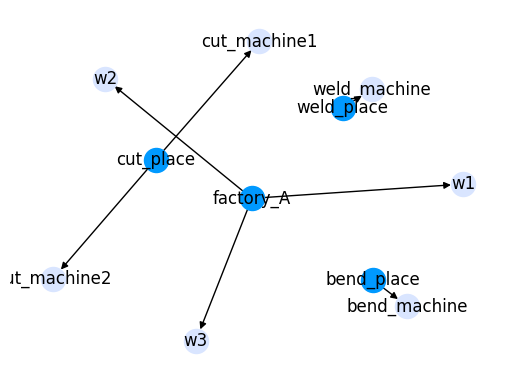

In [7]:
# Register Organization including Team in Project
team_list = [team]
workplace_list = [cut_place, bend_place, weld_place]
project.organization = BaseOrganization(team_list, workplace_list)

# draw organization network
project.organization.draw_networkx(view_workers=True, view_facilities=True)

## Define dependencies beteween each model and tasks

In [8]:

# Component <-> Task 
a1.append_targeted_task(cutting_a1)
a2.append_targeted_task(cutting_a2)
a3.extend_targeted_task_list([cutting_a3,bending_a3])
b.append_targeted_task(welding_b)
c.append_targeted_task(welding_c)


# Team <-> Task
team.extend_targeted_task_list([cutting_a1,cutting_a2,cutting_a3,bending_a3,welding_b,welding_c])

# Workplace <-> Task
cut_place.extend_targeted_task_list([cutting_a1,cutting_a2,cutting_a3])
bend_place.extend_targeted_task_list([bending_a3])
weld_place.extend_targeted_task_list([welding_b,welding_c])

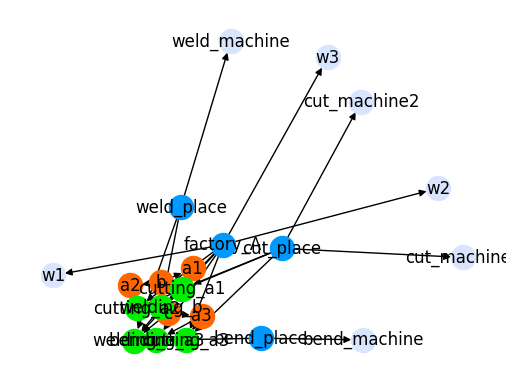

In [9]:
# draw project network 
project.draw_networkx(view_workers=True, view_facilities=True)

## Simulate Project

In [10]:
# Define max_time (the maximum number of simulations)
# you can see the simulation log, if you set 「print_debug =True」

project.simulate(max_time = 200, print_debug=True)

/usr/local/lib/python3.9/site-packages/pDESy/model/base_project.py:262: FutureWarning: `print_debug` mode will be extinguished in the next version. Please use `output_simlog()` function for debugging.
  warnings.warn(


---
0  True
ALLOCATE
Workplace - Component before setting components in this time
cut_place:
bend_place:
weld_place:
Ready Component list before allocating
a1,a2,a3
Workplace - Component after setting components in this time
cut_place:a1,a2,a3
bend_place:
weld_place:
Ready & Working Task List
[('cutting_a1', 10.0), ('cutting_a2', 10.0), ('cutting_a3', 20.0)]
Allocation result in this time
w1 : ['cutting_a1']
w2 : ['cutting_a3']
w3 : []
cut_machine1 : ['cutting_a1']
cut_machine2 : ['cutting_a3']
bend_machine : []
weld_machine : []
PERFORM
RECORD
UPDATE
---
1  True
ALLOCATE
Workplace - Component before setting components in this time
cut_place:a1,a2,a3
bend_place:
weld_place:
Ready Component list before allocating
a2
Workplace - Component after setting components in this time
cut_place:a1,a2,a3
bend_place:
weld_place:
Ready & Working Task List
[('cutting_a1', 8.5), ('cutting_a2', 10.0), ('cutting_a3', 19.0)]
Allocation result in this time
w1 : ['cutting_a1']
w2 : ['cutting_a3']
w3 : []
c

## Draw Gannt Chart based simulation output log

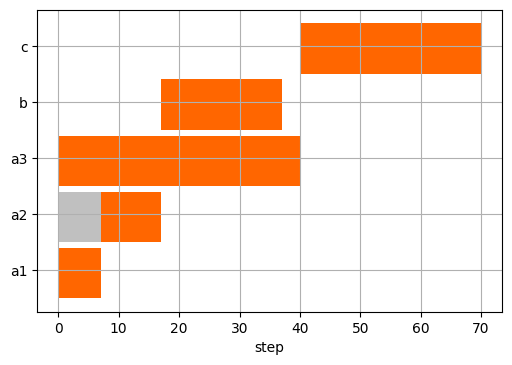

In [11]:
# Product Gannt Chart
# orange part ⇨　task state is "WORKING", gray part ⇨　task state is "READY"

project.product.create_simple_gantt(view_ready=True)

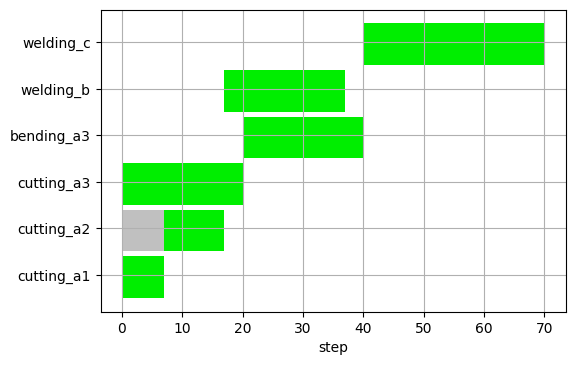

In [12]:
# Workflow Gannt Chart
# green part ⇨ task state is "WORKING", gray part　⇨ task state is "READY"
project.workflow.create_simple_gantt(view_auto_task=True, view_ready=True)

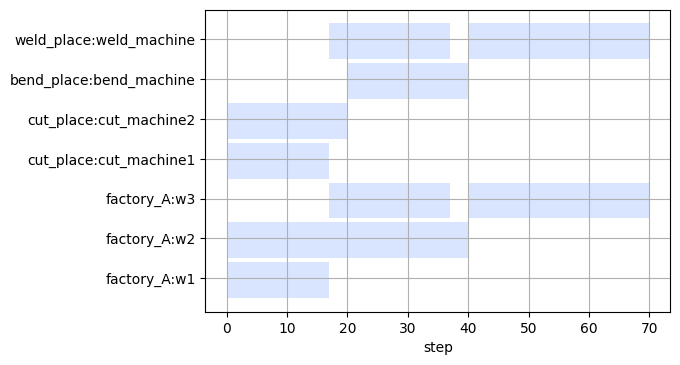

In [13]:
# Organization Gannt Chart
# Purple part　⇨ worker state is "WORKING"
project.organization.create_simple_gantt()

## OPTIONAL SETTING 

### ResourcePriorityRuleMode
* SSP  ⇦ default setting rule 
* VC  (Value Cost)
* HSV (High Skill Value)

### TaskPriorityRuleMode
* TSLACK  ⇦ default setting rule 
* EST    (Earliest Start Time)
* SPT    (Shortest Processing Time)
* LPT    (Longest Processing Time)
* FIFO   (First in First Out)
* LRPT   (Longest Remaining Process Time)
* SRPT   (Shortest Remaining Process Time)
* LWRPT  (Longest Workflow Remaining Process Time)
* SWRPT  (Shortest Workflow Remaining Process Time)

In [14]:
#If you want to use SPT rule, set "task_priority_rule=TaskPriorityRuleMode.SPT" in simulate()
project.simulate(max_time = 200, print_debug=True,task_priority_rule=TaskPriorityRuleMode.SPT)

---
0  True
ALLOCATE
Workplace - Component before setting components in this time
cut_place:
bend_place:
weld_place:
Ready Component list before allocating
a1,a2,a3
Workplace - Component after setting components in this time
cut_place:a1,a2,a3
bend_place:
weld_place:
Ready & Working Task List
[('cutting_a1', 10.0), ('cutting_a2', 10.0), ('cutting_a3', 20.0)]
Allocation result in this time
w1 : ['cutting_a2']
w2 : ['cutting_a1']
w3 : []
cut_machine1 : ['cutting_a1', 'cutting_a2']
cut_machine2 : []
bend_machine : []
weld_machine : []
PERFORM
RECORD
UPDATE
---
1  True
ALLOCATE
Workplace - Component before setting components in this time
cut_place:a1,a2,a3
bend_place:
weld_place:
Ready Component list before allocating
a3
Workplace - Component after setting components in this time
cut_place:a1,a2,a3
bend_place:
weld_place:
Ready & Working Task List
[('cutting_a1', 9.5), ('cutting_a2', 9.5), ('cutting_a3', 20.0)]
Allocation result in this time
w1 : ['cutting_a2']
w2 : ['cutting_a1']
w3 : []


### Gantt Chart Color 
* If you want to change color for Gsntt Chart, select HTML code and set it in create_simple_gantt
* https://htmlcolorcodes.com

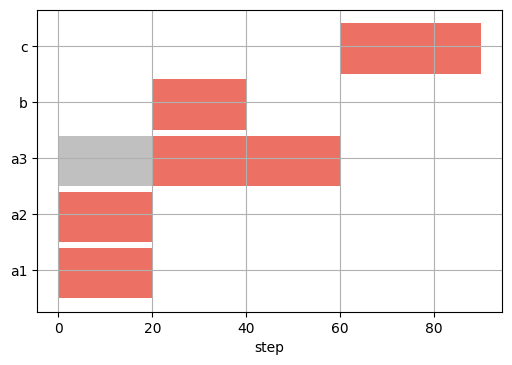

In [15]:
project.product.create_simple_gantt(view_ready=True,component_color="#EC7063")

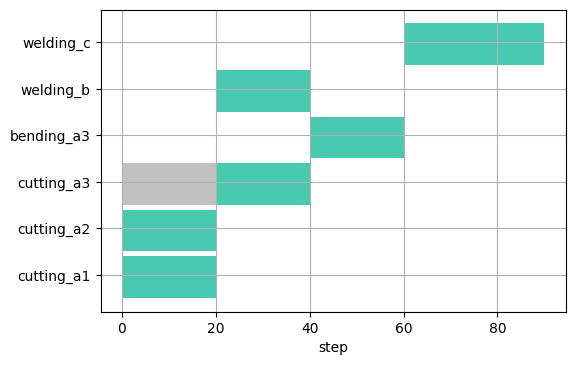

In [16]:
project.workflow.create_simple_gantt(view_auto_task=True, view_ready=True,task_color="#48C9B0")

## Out Put Data

In [17]:
print("w1 : "+str(sum(team.worker_list[0].cost_list)))
print("w2 : "+str(sum(team.worker_list[1].cost_list)))
print("w3 : "+str(sum(team.worker_list[2].cost_list))) 

w1 : 200.0
w2 : 600.0
w3 : 500.0


In [18]:
print("w1")
team.worker_list[0].state_record_list

w1


[<BaseWorkerState.WORKING: 1>,
 <BaseWorkerState.WORKING: 1>,
 <BaseWorkerState.WORKING: 1>,
 <BaseWorkerState.WORKING: 1>,
 <BaseWorkerState.WORKING: 1>,
 <BaseWorkerState.WORKING: 1>,
 <BaseWorkerState.WORKING: 1>,
 <BaseWorkerState.WORKING: 1>,
 <BaseWorkerState.WORKING: 1>,
 <BaseWorkerState.WORKING: 1>,
 <BaseWorkerState.WORKING: 1>,
 <BaseWorkerState.WORKING: 1>,
 <BaseWorkerState.WORKING: 1>,
 <BaseWorkerState.WORKING: 1>,
 <BaseWorkerState.WORKING: 1>,
 <BaseWorkerState.WORKING: 1>,
 <BaseWorkerState.WORKING: 1>,
 <BaseWorkerState.WORKING: 1>,
 <BaseWorkerState.WORKING: 1>,
 <BaseWorkerState.WORKING: 1>,
 <BaseWorkerState.FREE: 0>,
 <BaseWorkerState.FREE: 0>,
 <BaseWorkerState.FREE: 0>,
 <BaseWorkerState.FREE: 0>,
 <BaseWorkerState.FREE: 0>,
 <BaseWorkerState.FREE: 0>,
 <BaseWorkerState.FREE: 0>,
 <BaseWorkerState.FREE: 0>,
 <BaseWorkerState.FREE: 0>,
 <BaseWorkerState.FREE: 0>,
 <BaseWorkerState.FREE: 0>,
 <BaseWorkerState.FREE: 0>,
 <BaseWorkerState.FREE: 0>,
 <BaseWorkerStat

In [19]:
print("w1")
team.worker_list[0]. assigned_task_id_record 

w1


[['fedbffce-0538-4e00-a62f-8f31d9dfc6d3'],
 ['fedbffce-0538-4e00-a62f-8f31d9dfc6d3'],
 ['fedbffce-0538-4e00-a62f-8f31d9dfc6d3'],
 ['fedbffce-0538-4e00-a62f-8f31d9dfc6d3'],
 ['fedbffce-0538-4e00-a62f-8f31d9dfc6d3'],
 ['fedbffce-0538-4e00-a62f-8f31d9dfc6d3'],
 ['fedbffce-0538-4e00-a62f-8f31d9dfc6d3'],
 ['fedbffce-0538-4e00-a62f-8f31d9dfc6d3'],
 ['fedbffce-0538-4e00-a62f-8f31d9dfc6d3'],
 ['fedbffce-0538-4e00-a62f-8f31d9dfc6d3'],
 ['fedbffce-0538-4e00-a62f-8f31d9dfc6d3'],
 ['fedbffce-0538-4e00-a62f-8f31d9dfc6d3'],
 ['fedbffce-0538-4e00-a62f-8f31d9dfc6d3'],
 ['fedbffce-0538-4e00-a62f-8f31d9dfc6d3'],
 ['fedbffce-0538-4e00-a62f-8f31d9dfc6d3'],
 ['fedbffce-0538-4e00-a62f-8f31d9dfc6d3'],
 ['fedbffce-0538-4e00-a62f-8f31d9dfc6d3'],
 ['fedbffce-0538-4e00-a62f-8f31d9dfc6d3'],
 ['fedbffce-0538-4e00-a62f-8f31d9dfc6d3'],
 ['fedbffce-0538-4e00-a62f-8f31d9dfc6d3'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],


## What is Auto Task

* you can adjust the time to put a product into the production line by using "Auto task"

In [20]:
#define another project 

project2 = BaseProject(init_datetime = datetime.datetime(2021, 5, 2,8, 0, 0), unit_timedelta=datetime.timedelta(days=1))

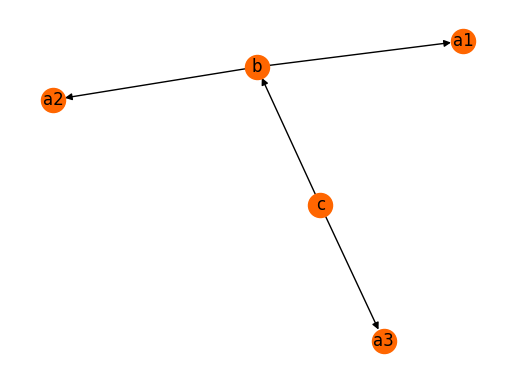

In [21]:
# Register Product including Components in Project
project2.product = BaseProduct([a1, a2, a3, b, c])

# draw produt network
project2.product.draw_networkx()



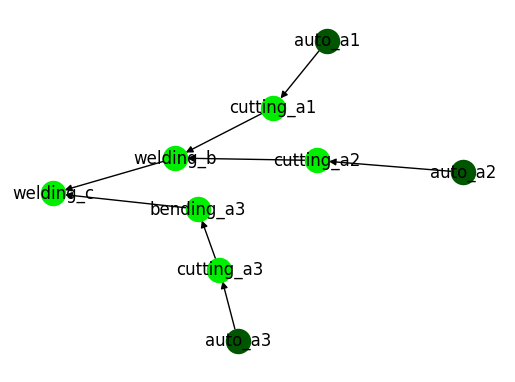

In [22]:
# Tasks in Workflow 
# define work_amount and whether or not to need facility for each task
auto_a1 = BaseTask('auto_a1', auto_task=True,default_work_amount=10)
auto_a2 = BaseTask('auto_a2', auto_task=True,default_work_amount=15)
auto_a3 = BaseTask('auto_a3', auto_task=True,default_work_amount=5)
cutting_a1 = BaseTask('cutting_a1', need_facility=True, default_work_amount=10)
cutting_a2 = BaseTask('cutting_a2', need_facility=True, default_work_amount=10)
cutting_a3 = BaseTask('cutting_a3', need_facility=True, default_work_amount=20)
bending_a3 = BaseTask('bending_a3', need_facility=True, default_work_amount=20)
welding_b = BaseTask('welding_b', need_facility=True, default_work_amount=20)
welding_c= BaseTask('welding_c', need_facility=True, default_work_amount=30)

# dependencies between tasks

welding_c.extend_input_task_list([bending_a3, welding_b])
bending_a3.append_input_task(cutting_a3)
cutting_a1.append_input_task(auto_a1)
cutting_a2.append_input_task(auto_a2)
cutting_a3.append_input_task(auto_a3)
welding_b.extend_input_task_list([cutting_a1,cutting_a2])

# Register Workflow including Tasks in Project
project2.workflow = BaseWorkflow([auto_a1,auto_a2,auto_a3,cutting_a1,cutting_a2,cutting_a3,bending_a3,welding_b,welding_c])

# draw workflow network
project2.workflow.draw_networkx()

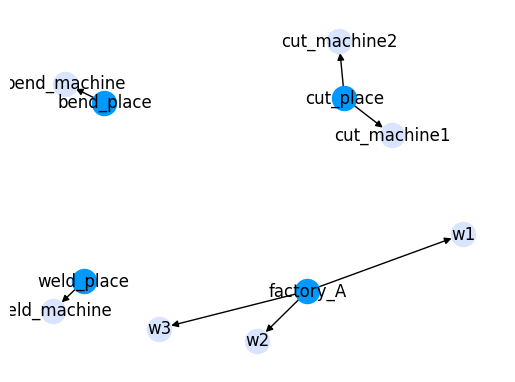

In [23]:

project2.organization = BaseOrganization(team_list, workplace_list)

# draw organization network
project2.organization.draw_networkx(view_workers=True, view_facilities=True)

In [24]:

# Component <-> Task 
a1.extend_targeted_task_list([auto_a1,cutting_a1])
a2.extend_targeted_task_list([auto_a2,cutting_a2])
a3.extend_targeted_task_list([auto_a3,cutting_a3,bending_a3])
b.append_targeted_task(welding_b)
c.append_targeted_task(welding_c)


# Team <-> Task
team.extend_targeted_task_list([auto_a1,auto_a2,auto_a3,cutting_a1,cutting_a2,cutting_a3,bending_a3,welding_b,welding_c])

# Workplace <-> Task
cut_place.extend_targeted_task_list([cutting_a1,cutting_a2,cutting_a3])
bend_place.extend_targeted_task_list([bending_a3])
weld_place.extend_targeted_task_list([welding_b,welding_c])

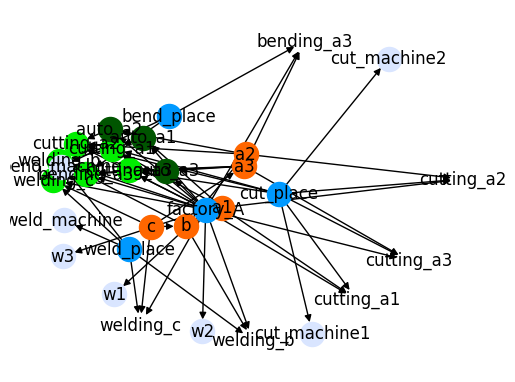

In [25]:
# draw project network 
project2.draw_networkx(view_workers=True, view_facilities=True)

In [26]:
# Define max_time (the maximum number of simulations)
# you can see the simulation log, if you set 「print_debug =True」

project2.simulate(max_time = 200, print_debug=True)

---
0  True
ALLOCATE
Workplace - Component before setting components in this time
cut_place:
bend_place:
weld_place:
Ready Component list before allocating
a1,a2,a3
Workplace - Component after setting components in this time
cut_place:
bend_place:
weld_place:
Ready & Working Task List
[('auto_a1', 10.0), ('auto_a2', 15.0), ('auto_a3', 5.0)]
Allocation result in this time
w1 : []
w2 : []
w3 : []
cut_machine1 : []
cut_machine2 : []
bend_machine : []
weld_machine : []
PERFORM
RECORD
UPDATE
---
1  True
ALLOCATE
Workplace - Component before setting components in this time
cut_place:
bend_place:
weld_place:
Ready Component list before allocating

Workplace - Component after setting components in this time
cut_place:
bend_place:
weld_place:
Ready & Working Task List
[('auto_a1', 9.0), ('auto_a2', 14.0), ('auto_a3', 4.0)]
Allocation result in this time
w1 : []
w2 : []
w3 : []
cut_machine1 : []
cut_machine2 : []
bend_machine : []
weld_machine : []
PERFORM
RECORD
UPDATE
---
2  True
ALLOCATE
Work

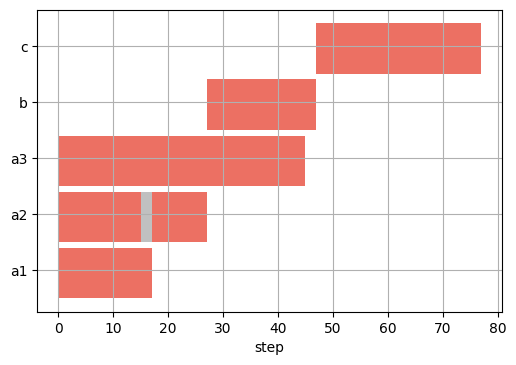

In [27]:
project2.product.create_simple_gantt(view_ready=True,component_color="#EC7063")

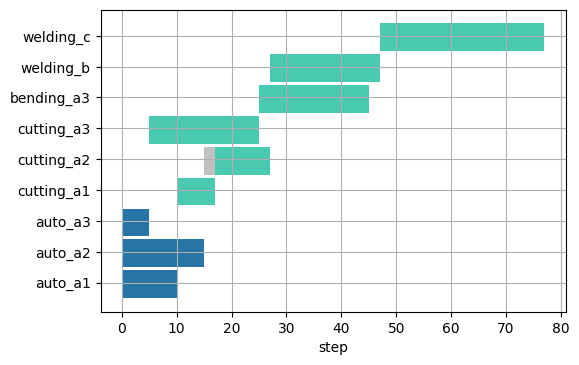

In [28]:
project2.workflow.create_simple_gantt(view_auto_task=True, view_ready=True,auto_task_color="#2874A6",task_color="#48C9B0")

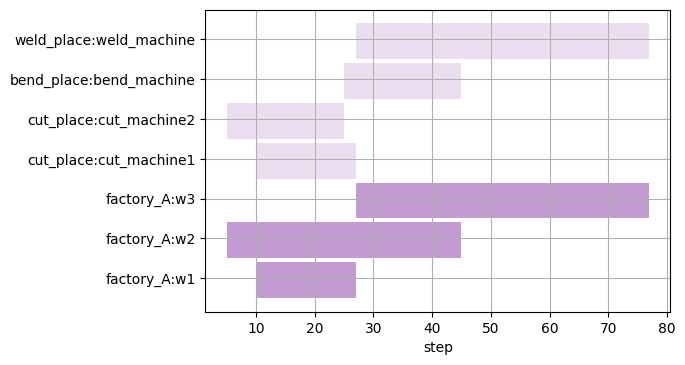

In [29]:
project2.organization.create_simple_gantt(worker_color="#C39BD3",workplace_color="#0099FF",facility_color="#EBDEF0")